In [1]:
!pip install itkwidgets

     |████████████████████████████████| 3.4 MB 4.4 MB/s 
     |████████████████████████████████| 259 kB 36.2 MB/s 
     |████████████████████████████████| 2.0 MB 27.6 MB/s 
     |████████████████████████████████| 50.1 MB 208 kB/s 
     |████████████████████████████████| 68.0 MB 97.5 MB/s 
     |████████████████████████████████| 593 kB 27.0 MB/s 
     |████████████████████████████████| 36.3 MB 34.4 MB/s 
     |████████████████████████████████| 2.4 MB 29.7 MB/s 


In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from sklearn.cluster import KMeans
from itkwidgets import view
import itkwidgets
from ipywidgets import interact,fixed

In [3]:
inputVolume = nib.load("./Brain_Tumor/BRATS_001.nii")
data = inputVolume.get_fdata()

inputMask = nib.load("./Brain_Tumor/BRATS_001_tumor_mask.nii")
mask_data =  inputMask.get_fdata()

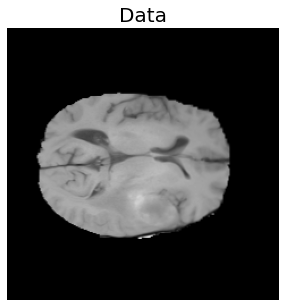

In [4]:
def explore_3dimage_axial(layer, contrast, input_data):
    plt.figure(figsize=(10, 5))
    plt.imshow(input_data[:, :, layer, contrast], cmap='gray');
    plt.title('Data', fontsize=20)
    plt.axis('off')

interact(explore_3dimage_axial, layer=(0, data.shape[2] - 1),
         contrast=(0, data.shape[3] - 1),input_data=fixed(data));

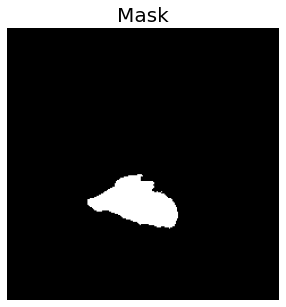

In [5]:
def explore_3dimage_axial(layer, input_data):
    plt.figure(figsize=(10, 5))
    plt.imshow(input_data[:, :, layer], cmap='gray');
    plt.title('Mask', fontsize=20)
    plt.axis('off')

interact(explore_3dimage_axial, layer=(0, mask_data.shape[2] - 1), input_data=fixed(mask_data));

# Apply the mask

In [6]:
inputSizeX = data.shape[0]
inputSizeY = data.shape[1]
inputSizeZ = data.shape[2]
inputSizeC = data.shape[3]

for c in range(inputSizeC):
    for z in range( inputSizeZ ):
        for y in range( inputSizeY ):
            for x in range( inputSizeX ):
                if(mask_data[x, y, z]>0):
                    data[ x, y, z, c ] = data[ x, y, z, c ]
                else:
                    data[x,y,z, c]=1
                

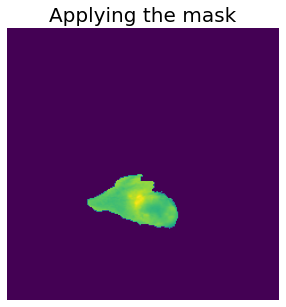

In [7]:
def explore_3dimage_axial(layer, contrast, input_data):
    plt.figure(figsize=(10, 5))
    plt.imshow(input_data[:, :, layer, contrast], cmap='viridis');
    plt.title('Applying the mask', fontsize=20)
    plt.axis('off')

interact(explore_3dimage_axial, layer=(0, data.shape[2] - 1),
         contrast=(0, data.shape[3] - 1),input_data=fixed(data));

# Segmentation

In [8]:
all_img=[]

inputSizeX = data.shape[0]
inputSizeY = data.shape[1]
for C in range(data.shape[3]):
    img=[]
    for Z in range(data.shape[2]):
        data2 = data[:,:,Z,C].reshape(-1, 1)
        kmeans = KMeans(n_clusters=3, random_state=0)
        kmeans.fit(data2)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        img.append(centers[labels].reshape(inputSizeX, inputSizeY))

    all_img.append(img)
    
all_img=np.array(all_img)

Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
Number of distinct clusters (1) found smaller 

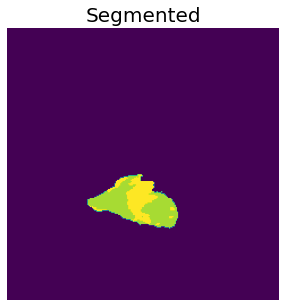

In [9]:
def explore_3dimage_axial(layer, contrast, input_data):
    plt.figure(figsize=(10, 5))
    plt.imshow(input_data[contrast, layer, :, :], cmap='viridis');
    plt.title('Segmented', fontsize=20)
    plt.axis('off')

interact(explore_3dimage_axial, layer=(0, all_img.shape[1] - 1), 
         contrast=(0, all_img.shape[0] - 1), input_data=fixed(all_img));

In [10]:
img = nib.Nifti1Image(all_img, np.eye(4))  

img.header.get_xyzt_units()
img.to_filename("./BRATS_001_tumor_kmeans_segmentation.nii")  

# 3D representation

In [11]:
# Here I will do the 3D representation of the third contrast
third_contrast_volume = all_img[2]

In [12]:
pixel_spacing = [inputVolume.header.get_zooms()[0], inputVolume.header.get_zooms()[1]]
slice_thickness = inputVolume.header.get_zooms()[2]

In [13]:
# In our case we didn't need to modify the data as both the spacing and the thickness = 1

def resample(third_contrast_volume, pixel_spacing, slice_thickness, new_spacing=[1,1,1]):
    
    spacing = [float(slice_thickness), float(pixel_spacing[0]), 
               float(pixel_spacing[1])]
    
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = third_contrast_volume.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / third_contrast_volume.shape
    new_spacing = spacing / real_resize_factor
    
    third_contrast_volume = scipy.ndimage.interpolation.zoom(third_contrast_volume, real_resize_factor)
    
    return third_contrast_volume, new_spacing

print ("Shape before resampling\t", data[:,:,:,2].shape)
data_after_resamp, spacing = resample(data[:,:,:,2], pixel_spacing, slice_thickness, [1,1,1])
print ("Shape after resampling\t", data_after_resamp.shape)

print ("Shape before resampling\t", third_contrast_volume.shape)
third_contrast_volume_after_resamp, spacing = resample(third_contrast_volume, pixel_spacing, slice_thickness, [1,1,1])
print ("Shape after resampling\t", third_contrast_volume_after_resamp.shape)

Shape before resampling	 (240, 240, 155)
Shape after resampling	 (240, 240, 155)
Shape before resampling	 (155, 240, 240)
Shape after resampling	 (155, 240, 240)


In [14]:
third_contrast_volume_after_resamp = third_contrast_volume_after_resamp.transpose(2,1,0)

In [15]:
# 3D representation of the tumor
view(data_after_resamp, cmap=itkwidgets.cm.viridis, annotations=False, vmax=800)

Viewer(annotations=False, cmap=['Viridis (matplotlib)'], geometries=[], gradient_opacity=0.22, point_sets=[], …

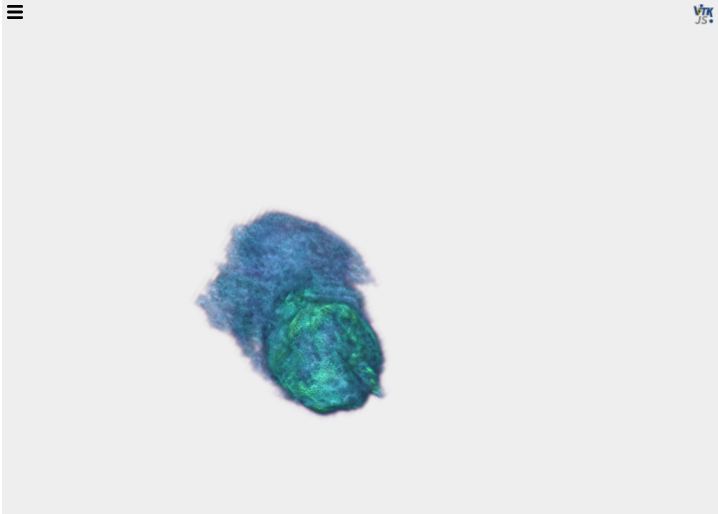

In [16]:
# 3D representation of the segmented tumor
view(third_contrast_volume_after_resamp, cmap=itkwidgets.cm.viridis, annotations=False, vmax=800)

Viewer(annotations=False, cmap=['Viridis (matplotlib)'], geometries=[], gradient_opacity=0.22, point_sets=[], …

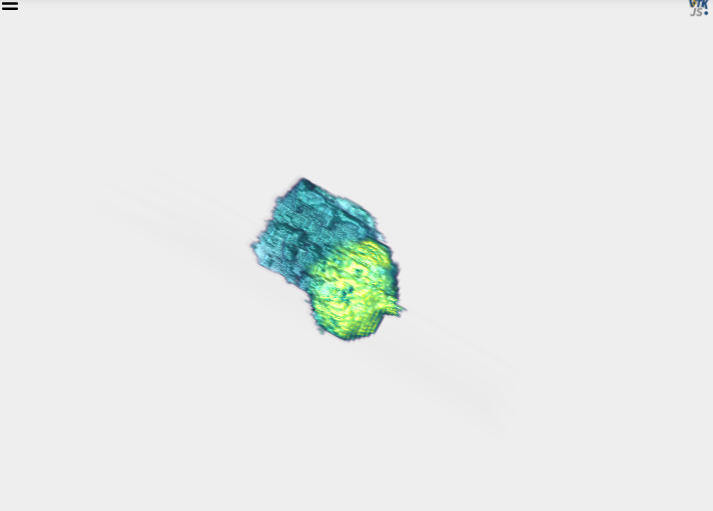

# Sample dashboard

In [17]:
import json

from ipywidgets.embed import embed_data

data = embed_data(views=[view(data_after_resamp, cmap=itkwidgets.cm.viridis, annotations=False, vmax=800), view(third_contrast_volume_after_resamp, cmap=itkwidgets.cm.viridis, annotations=False, vmax=800)])

html_template = """
<html>
  <head>

    <title>Widget export</title>

    <!-- Load RequireJS, used by the IPywidgets for dependency management -->
    <script 
      src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" 
      integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" 
      crossorigin="anonymous">
    </script>

    <!-- Load IPywidgets bundle for embedding. -->
    <script
      data-jupyter-widgets-cdn="https://cdn.jsdelivr.net/npm/"
      src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" 
      crossorigin="anonymous">
    </script>

    <!-- The state of all the widget models on the page -->
    <script type="application/vnd.jupyter.widget-state+json">
      {manager_state}
    </script>
  </head>

  <body>

    <h1>Widget export</h1>

    <div id="first-slider-widget">
      <!-- This script tag will be replaced by the view's DOM tree -->
      <script type="application/vnd.jupyter.widget-view+json">
        {widget_views[0]}
      </script>
    </div>

    <hrule />

    <div id="second-slider-widget">
      <!-- This script tag will be replaced by the view's DOM tree -->
      <script type="application/vnd.jupyter.widget-view+json">
        {widget_views[1]}
      </script>
    </div>

  </body>
</html>
"""

manager_state = json.dumps(data['manager_state'])
widget_views = [json.dumps(view) for view in data['view_specs']]
rendered_template = html_template.format(manager_state=manager_state, widget_views=widget_views)
with open('export.html', 'w') as fp:
    fp.write(rendered_template)

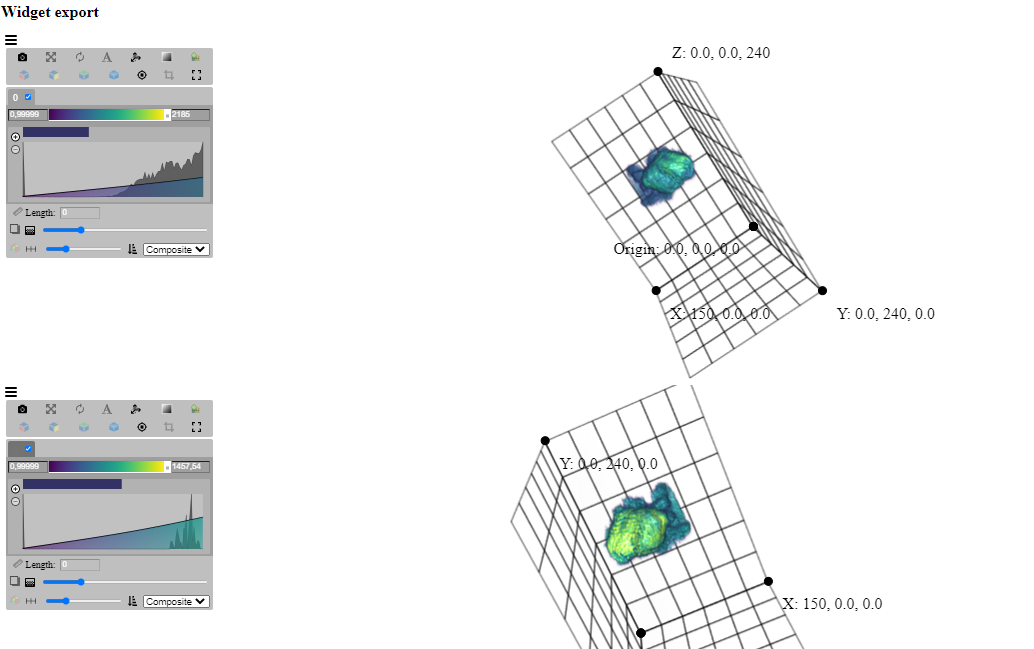

-------------------------------------------------------------------------------------------------------------------------------
Copyright:
 
The data was provided by Ms.Linda Marrakchi-Kacem

-------------------------------------------------------------------------------------------------------------------------------